In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier

In [92]:
classifiers = [("Logistic Regression",LogisticRegression(multi_class='multinomial', 
                                                solver='newton-cg', class_weight='balanced')),
               ("Naive Bayes",GaussianNB()),
               ("Linear Discriminant Analysis",LinearDiscriminantAnalysis(n_components=None, priors=None, 
                                                shrinkage=None, solver='svd', store_covariance=False, tol=0.0001)),
               ("AdaBoost",AdaBoostClassifier())
              ]

Accuracy_dict = {}

In [93]:
dataset = pd.read_excel('preProcessedFlu.xlsx')
dataset.describe()

,Vaccin,HndWshQual,SocialDist,NotTchFace,PrsnlDist,HandSanit,Risk,Barriers,Inefficacy,KnowlMgmt,Gender,Flu
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,0.593931,0.726879,0.479046,0.364162,0.597543,0.450145,0.456706,0.405434,0.483232,0.602235,0.543353,0.193642
std,0.324472,0.255746,0.293211,0.302720,0.278560,0.401365,0.163183,0.115771,0.155013,0.233005,0.498838,0.395724
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.500000,0.250000,0.250000,0.500000,0.000000,0.370613,0.343652,0.380307,0.500000,0.000000,0.000000
50%,0.500000,0.750000,0.500000,0.250000,0.500000,0.500000,0.500000,0.392360,0.500000,0.613023,1.000000,0.000000
75%,1.000000,1.000000,0.500000,0.500000,0.750000,0.750000,0.558156,0.460381,0.589623,0.730769,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [94]:
columns = list(dataset)
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1:].values

In [95]:
#TrainTest Split - 80:20
X_train,X_test,Y_train,Y_test = train_test_split(X,y, stratify=y, train_size = 0.2,
                                                random_state = 42)

In [96]:
  
def compute_metrics(classifier, predictions, Y_test):
   
    print("Metrics for ",classifier)
    print("Test Accuracy : ", metrics.accuracy_score(Y_test, predictions))
    
    y_actu = pd.Series(np.reshape(Y_test,len(Y_test)), name='Actual')
    y_pred = pd.Series(np.reshape(predictions, len(predictions)), name='Predicted')
    
    y_act = pd.Categorical(y_actu, categories=[0,1])
    y_pre = pd.Categorical(y_pred, categories=[0,1])
    
    #F1 score
    from sklearn.metrics import f1_score
    print("Average F1 score is {}".format(f1_score(Y_test, predictions, average='weighted', labels = [0,1])))
    
    df_confusion = pd.crosstab(y_act, y_pre, rownames =['Actual'],colnames=['Predicted'])
    print("Confusion matrix: \n", df_confusion)
    #pprint.pprint(df_confusion)
    
    #Need to one hot encode for computing ROC
    n_classes = 2
    onh = OneHotEncoder()
    Y_test = Y_test.reshape((len(Y_test),1))
    predictions = predictions.reshape((len(predictions),1))
    Y_test = onh.fit_transform(Y_test).toarray()
    predictions = onh.fit_transform(predictions).toarray()
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    lw = 2
    # Compute macro-average ROC curve and ROC area
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i+1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()


/Users/ass6ash/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Metrics for  Logistic Regression
Test Accuracy :  0.685920577617
Average F1 score is 0.7125361431704909
Confusion matrix: 
 Predicted    0   1
Actual            
0          160  63
1           24  30


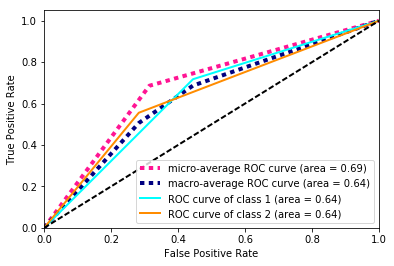



Metrics for  Naive Bayes
Test Accuracy :  0.787003610108
Average F1 score is 0.7774899091002597
Confusion matrix: 
 Predicted    0   1
Actual            
0          199  24
1           35  19


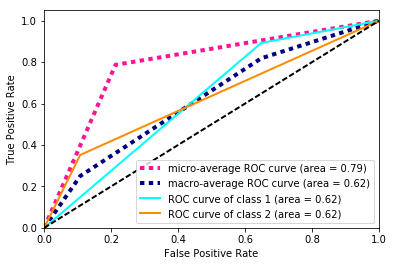



Metrics for  Linear Discriminant Analysis
Test Accuracy :  0.787003610108
Average F1 score is 0.773291716000098
Confusion matrix: 
 Predicted    0   1
Actual            
0          201  22
1           37  17


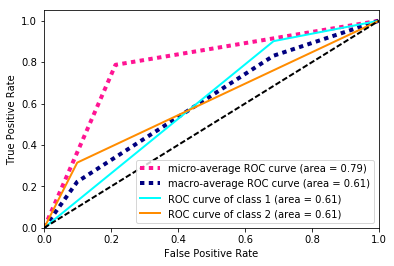



Metrics for  AdaBoost
Test Accuracy :  0.743682310469
Average F1 score is 0.7560333577373288
Confusion matrix: 
 Predicted    0   1
Actual            
0          179  44
1           27  27


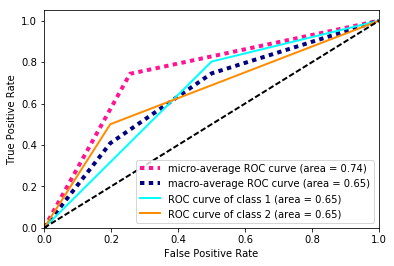

In [97]:
#Time for training

for name,classifier in classifiers:
    accuracies=[]
    classifier.fit(X_train, Y_train)
    predictions = classifier.predict(X_test)
    accuracies.append(metrics.accuracy_score(Y_test, predictions))
    compute_metrics(name,predictions,Y_test)
    Accuracy_dict[name] = accuracies
    print("\n====================================\n")
